In [1]:
using Distributions
using Turing
using PyPlot
using StatsPlots


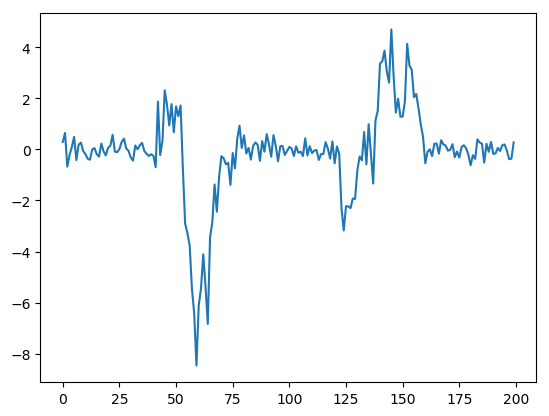

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000065FC98D0>

In [2]:
# Generate data
μ_θ = 0.9    # AR coef mean
σ_θ = 0.2    # AR coef std
σ_s = 1      # AR innovation std

σ_n = 0.3    # noise std

xt = Float64[]
for k = 1:200
    
    if k % 80 > 40
        # AR
        θ = rand(Normal(μ_θ, σ_θ))
        push!(xt, rand(Normal(xt[k-1]*θ, σ_s)))
    else
        push!(xt, 0.0)
    end
end

# add noise
xt = xt + rand(Normal(0,σ_n), length(xt))

plt.plot(xt)

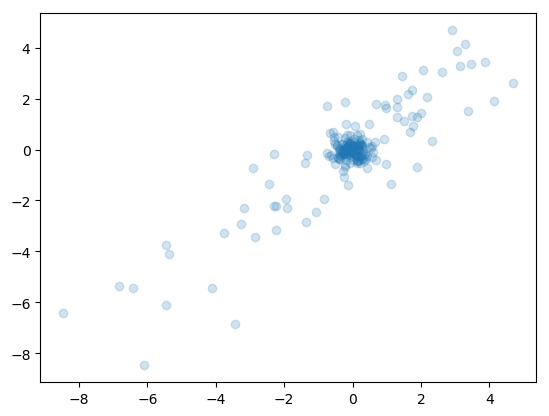

PyObject <matplotlib.collections.PathCollection object at 0x00000000665A7828>

In [7]:
# plot against previous variable
plt.scatter(xt[2:end], xt[1:end-1], alpha=0.2)

# line with AR slope and dot in middle for noise

In [19]:
@model AR1(x) = begin

    # sample segments
    nr_segments = 20
    π1 ~ Beta(1,1)
    z = Vector(undef, nr_segments)
    z[1] ~ Categorical([π1, 1-π1])
    T = Vector{Vector}(undef, 2)
    T[1] ~ Dirichlet([1,1])
    T[2] ~ Dirichlet([1,1])
    for zn = 2:nr_segments
        z[zn] ~ Categorical(vec(T[z[zn-1]]))
    end
    
    # prior distributions
    μθ ~ Normal()
    σθ ~ InverseGamma()
    σs ~ InverseGamma()
    σn ~ InverseGamma()
    θ ~ Normal(μθ, σθ)
    
    # samples
    x[1] ~ Normal()
    xh = Vector(undef, length(x))
    xh[1] ~ Normal()
    for n = 2:length(x)

        if z[Int(ceil(n*nr_segments/length(x)))] == 1
            xh[n] ~ Normal(θ*xh[n-1], σs)
        else
            xh[n] ~ Normal(0*xh[n-1], 1e-10)
        end
        x[n] ~ Normal(xh[n], σn)
    end
    
    
    return μθ, σθ, σs, σn
end

##AR1#1280 (generic function with 2 methods)

In [22]:
# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 50
ϵ = 0.02
τ = 20

#sampler = HMC(ϵ, τ)
#sampler = NUTS(200, 0.6)
sampler = Gibbs(PG(500, :z), HMC(ϵ, τ, :μθ))


# Start sampling.
chain = sample(AR1(xt), sampler, iterations);

Sampling: 100%|█████████████████████████████████████████| Time: 0:03:12


UndefVarError: UndefVarError: σ not defined

In [23]:
describe(chain)

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters      mean     std  naive_se     mcse      ess   r_hat
  ──────────  ────────  ──────  ────────  ───────  ───────  ──────
     T[1][1]    0.6427  0.0000    0.0000  missing      NaN     NaN
     T[1][2]    0.3573  0.0000    0.0000  missing      NaN     NaN
     T[2][1]    0.9519  0.0000    0.0000  missing   2.1739  1.3466
     T[2][2]    0.0481  0.0000    0.0000  missing   2.1739  2.2978
       xh[1]   -2.6431  0.0000    0.0000  missing      NaN     NaN
       xh[2]    0.0000  0.0000    0.0000  missing      NaN     NaN
       xh[3]   -0.0000  0.0000    0.0000  missing   2.1739  1.6971
       xh[4]    0.0000  0.0000    0.0000  missing   2.1739  1.6971
       xh[5]    0.0000  0.0000    0.0000  missing   2.1739  1.6971
       xh[6]    0.0000  0.0000    0.0000  missing   2.1739  2.0913
       xh[7]    0.0000  0.0000    0.0000  missing   2.1739  1.6971
       xh[8]    0.0000  0.0000    0.0000  missing      NaN     NaN
       x

In [25]:
summary(chain[:θ])

"Chains{Float64,Missing,NamedTuple{(:parameters,),Tuple{Array{String,1}}},NamedTuple{(),Tuple{}}}"

In [ ]:
using ForneyLab
using LAR
using LAR.Node

include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")

$$ p(y_t \mid x_t) = \mathcal{N}(y_t \mid x_t, \ \sigma_n^2) $$
$$ p(x_t \mid x_{t-1}, \theta_n, \gamma_n) = \mathcal{N}(x_t \mid \theta_n x_{t-1}, \ \gamma_n^{-1})$$
$$ p(\gamma_n) = \Gamma(\gamma_n \mid a, b) $$
$$ p(\theta_n \mid \theta_0, \ \theta_1, \ z_n) = \prod_{n=1}^N p(\theta_n)^{z_n}$$
$$ p(\theta_0) = \mathcal{N}(\theta_0 \mid \mu_0, \ \Lambda_0^{-1}) $$
$$ p(\theta_1) = \mathcal{N}(\theta_1 \mid \mu_1, \ \Lambda_1^{-1}) $$
$$ p(z_n \mid \phi_n) = \mathcal{Ber}(\phi_n) $$ 
$$ p(\phi_n) = Beta(a_n, b_n) $$

In [ ]:
fg = FactorGraph()


# placeholders
z = Array{Variable,1}(undef, 5)
phi = Array{Variable,1}(undef, 5)
θ = Array{Variable,1}(undef, 5)
γ = Array{Variable,1}(undef, 5)
x = Array{Array{Variable,1},1}(undef,5)
y = Array{Array{Variable,1},1}(undef,5)
for s = 1:5
    x[s] = Array{Variable,1}(undef, 40)
    y[s] = Array{Variable,1}(undef, 40)
end

# Marginals for first component
@RV W_1 ~ ForneyLab.Wishart(mat(1.0), 1.)
@RV m_1 ~ GaussianMeanPrecision([0.0], W_1)

# Marginals of second component
@RV W_2 ~ ForneyLab.Wishart(mat(1.0), 1.)
@RV m_2 ~ GaussianMeanPrecision([0.0], W_2)

# loop through segments
for s = 1:5
    
    @RV [id=pad(:ϕ, s)] phi[s] ~ ForneyLab.Beta(placeholder(pad(:ϕa, s)), placeholder(pad(:ϕb, s)))

    @RV [id=pad(:z, s)] z[s] ~ ForneyLab.Bernoulli(phi[s])
    
    @RV [id=pad(:θ, s)] θ[s] ~ GaussianMixture(z[s], m_1, W_1, m_2, W_2)
    
    @RV [id=pad(pad(:x, s),1)] x[s][1] ~ GaussianMeanPrecision([0], mat(tiny))
    @RV [id=pad(pad(:y, s),1)] y[s][1] ~ GaussianMeanPrecision(x[s][1], mat(0.001))   
    placeholder(y[s][1], pad(:y, (s-1)*40 + 1, len=4), dims=(1,))


    @RV [id=pad(:γ, s)] γ[s] ~ ForneyLab.Gamma(0.001, 0.001)
    
    for i = 2:40
        @RV [id=pad(pad(:x, s),i)] x[s][i] ~ LAR.Autoregressive(θ[s], x[s][i-1], γ[s])
        @RV [id=pad(pad(:y, s),i)] y[s][i] ~ GaussianMeanPrecision(x[s][i], mat(0.001))
        placeholder(y[s][i], pad(:y, (s-1)*40 + i, len=4), dims=(1,))
    end
    
end
ForneyLab.draw(fg, external_viewer=:default)


In [318]:
q = RecognitionFactorization(phi, m_1, W_1, m_2, W_2, z, γ, θ, vcat(vcat(x...)...), ids=[:PH, :M1, :W1, :M2, :W2, :Z, :γ, :θ, :x])
algo = compatibility_fix(variationalAlgorithm(q))
algo_F = compatibility_fix(freeEnergyAlgorithm(q))

# evaluate algorithm
eval(Meta.parse(algo))
eval(Meta.parse(algo_F))
println(algo)
println(algo_F)
;

begin

function stepZ!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 10))

messages[1] = ruleVBBernoulliOut(nothing, marginals[:ϕ_05])
messages[2] = ruleVBGaussianMixtureZBer(marginals[:θ_05], nothing, marginals[:m_1], marginals[:W_1], marginals[:m_2], marginals[:W_2])
messages[3] = ruleVBBernoulliOut(nothing, marginals[:ϕ_04])
messages[4] = ruleVBGaussianMixtureZBer(marginals[:θ_04], nothing, marginals[:m_1], marginals[:W_1], marginals[:m_2], marginals[:W_2])
messages[5] = ruleVBBernoulliOut(nothing, marginals[:ϕ_03])
messages[6] = ruleVBGaussianMixtureZBer(marginals[:θ_03], nothing, marginals[:m_1], marginals[:W_1], marginals[:m_2], marginals[:W_2])
messages[7] = ruleVBBernoulliOut(nothing, marginals[:ϕ_02])
messages[8] = ruleVBGaussianMixtureZBer(marginals[:θ_02], nothing, marginals[:m_1], marginals[:W_1], marginals[:m_2], marginals[:W_2])
messages[9] = ruleVBBernoulliOut(nothing, marginals[:ϕ_01])
messages[10] = ruleVBGaussianMixtureZBer(margin

In [345]:

# phi
ϕa = Array{Float64, 1}(undef, 5)
ϕb = Array{Float64, 1}(undef, 5)
for i = 1:5
    ϕa[i] = 1
    ϕb[i] = 1
end


# Add to data dictionary
data = Dict()
for i = 1:length(xt)
    data[pad(:y, i, len=4)] = [xt[i]]
end
for i = 1:5
    data[pad(:ϕa, i)] = ϕa[i]
    data[pad(:ϕb, i)] = ϕb[i]
end



# Prepare recognition distributions
marginals = Dict()
marginals[:m_1] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m=[10], w=mat(1))
marginals[:W_1] = ProbabilityDistribution(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=mat(1.0), nu=2)
marginals[:m_2] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m=[0], w=mat(1))
marginals[:W_2] = ProbabilityDistribution(ForneyLab.MatrixVariate, ForneyLab.Wishart, v=100*mat(1.0), nu=3)
for i = 1:5
    marginals[pad(:ϕ,i)] = ProbabilityDistribution(ForneyLab.Beta, a=0.5, b=0.5)
    marginals[pad(:z,i)] = ProbabilityDistribution(ForneyLab.Bernoulli, p=0.5)
    marginals[pad(:θ,i)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanPrecision, m=[0], w=mat(tiny))
    marginals[pad(:γ,i)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=1, b=1)
end

iterations = 100
F = Float64[]

for it = 1:iterations
    stepx!(data, marginals)
    stepθ!(data, marginals)
    stepγ!(data, marginals)
    stepM1!(data, marginals)
    stepM2!(data, marginals)
    stepW1!(data, marginals)
    stepW2!(data, marginals)
    stepθ!(data, marginals)
    stepθ!(data, marginals)
    stepZ!(data, marginals)
    stepPH!(data, marginals)
    
    push!(F, freeEnergy(data, marginals))
    
end

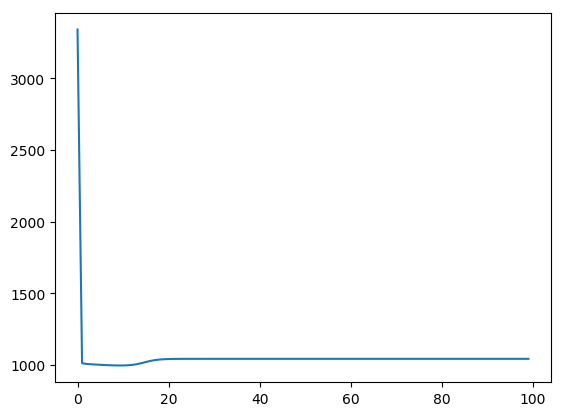

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000006EB79B70>

In [346]:
plt.plot(F)

In [347]:
F

100-element Array{Float64,1}:
 3341.614062279359 
 1013.4991743563984
 1008.1677875747023
 1005.9275898806053
 1004.0497208651677
 1002.3231558060144
 1000.725957886962 
  999.3086789193085
  998.1837450830426
  997.5294158929859
  997.5996304581199
  998.7584402232784
 1001.5101999939187
    ⋮              
 1043.9196623626244
 1043.9196623626256
 1043.9196623626353
 1043.9196623626608
 1043.9196623626628
 1043.9196623626776
 1043.9196623626685
 1043.919662362675 
 1043.9196623626842
 1043.91966236268  
 1043.9196623626813
 1043.9196623626974

In [348]:
marginals[:z_01]

Ber(p=0.50)
